## Preâmbulo


In [94]:
import numpy as np
import pandas as pd
import exp_physics as ep
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as scp

sns.set_style('darkgrid')

In [95]:
# Dados da luz azul variando intensidade

A20 = pd.read_csv('dados/A20.csv', delimiter=';', decimal=',').rename(columns={'Tensao [V]': 'V', "Corrente [A]":'i'})
A40 = pd.read_csv('dados/A40.csv', delimiter=';', decimal=',').rename(columns={'Tensao [V]': 'V', "Corrente [A]":'i'})
A60 = pd.read_csv('dados/A60.csv', delimiter=';', decimal=',').rename(columns={'Tensao [V]': 'V', "Corrente [A]":'i'})
A80 = pd.read_csv('dados/A80.csv', delimiter=';', decimal=',').rename(columns={'Tensao [V]': 'V', "Corrente [A]":'i'})
A100 = pd.read_csv('dados/A100.csv', delimiter=';', decimal=',').rename(columns={'Tensao [V]': 'V', "Corrente [A]":'i'})

Amarelo = pd.read_csv('dados/Amarelo.csv', delimiter=';', decimal=',').rename(columns={'Tensao [V]': 'V', "Corrente [A]":'i'})
Verde = pd.read_csv('dados/Verde.csv', delimiter=';', decimal=',').rename(columns={'Tensao [V]': 'V', "Corrente [A]":'i'})
Ultra = pd.read_csv('dados/Ultra.csv', delimiter=';', decimal=',').rename(columns={'Tensao [V]': 'V', "Corrente [A]":'i'})
Violeta = pd.read_csv('dados/Violeta.csv', delimiter=';', decimal=',').rename(columns={'Tensao [V]': 'V', "Corrente [A]":'i'})
Azul = pd.read_csv('dados/Azul.csv', delimiter=';', decimal=',').rename(columns={'Tensao [V]': 'V', "Corrente [A]":'i'})
Preto = pd.read_csv('dados/Preto.csv', delimiter=';', decimal=',').rename(columns={'Tensao [V]': 'V', "Corrente [A]":'i'})
Fundo = pd.read_csv('dados/Fundo.csv', delimiter=';', decimal=',').rename(columns={'Tensao [V]': 'V', "Corrente [A]":'i'})

In [96]:
l_Intensidade = [A20, A40, A60, A80, A100]

l_Cores = [Preto, Fundo, Amarelo, Verde, Azul, Violeta, Ultra]

In [97]:
def calc_sigma_i(i):
    if i < 10*10e-9:
        return i*(0.3/100) + 400 * 10e-14
    if i < 100*10e-9:
        return i*(0.2/100) + 1 * 10e-12
    else:
        return i*(0.15/100) + 10 * 10e-12

def calc_sigma_V(V):
    return V*(0.1/100) + 1 * 10e-3

In [98]:
for df in l_Intensidade:
    df['si'] = df['i'].apply(calc_sigma_i)
    df['sV'] = df['V'].apply(calc_sigma_V)

for df in l_Cores:
    df['si'] = df['i'].apply(calc_sigma_i)
    df['sV'] = df['V'].apply(calc_sigma_V)

In [99]:
l_Cores = [Amarelo, Verde, Azul, Violeta, Ultra]

nomes = ['Amarelo', 'Verde', 'Azul', 'Violeta', 'Ultravioleta']

paleta = ['gold', 'seagreen', 'royalblue', 'darkorchid', 'indigo']

In [100]:
def propaga_si(si1,si2):
    return np.sqrt(si1**2 + si2**2)

## Correção da corrente

Para corrigir a corrente, primeiro vamos remover o ruído da corrente de fundo sem o pano, subtraindo a corrente de fundo da corrente. Em seguida, vamos propagar as incertezas.

$$i^\prime = i - i_{fundo}$$

Podemos propagar por meio de:

$$\sigma_{i^\prime} = \sqrt{\sigma_i^2 + \sigma_{i_{fundo}}^2} $$

In [101]:
for df in l_Intensidade:
    df['i'] = df['i'] - Fundo['i']
    df['si'] = propaga_si(df['si'], Fundo['si'])

for df in l_Cores:
    df['i'] = df['i'] - Fundo['i']
    df['si'] = propaga_si(df['si'], Fundo['si'])

Agora vamos encontrar o valor da corrente do ânodo e subtrair, da mesma forma:

$$i_c = i^\prime - i_a$$

Faremos uma aproximação usando a região onde $i_c<0$, que deveria ser $i_c = 0$. Então, assumimos que:

$$i^\prime = i_c + i_a$$

$$\therefore i^\prime = i_a \text{, na região onde } i^\prime < 0$$

Vamos analisar as funções nesse intervalo:

Text(0.5, 1.0, 'Corrente por tensão quando $i<0$')

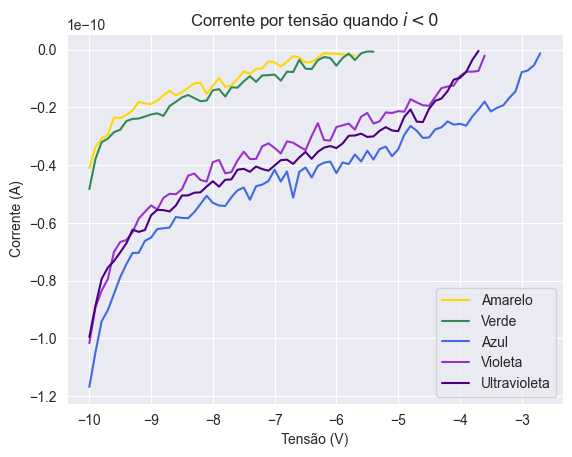

In [102]:
for i, cor in enumerate(l_Cores):
    sns.lineplot(x=cor['V'], y=cor[cor['i']<0]['i'], color=paleta[i], label=nomes[i])

plt.xlabel('Tensão (V)')
plt.ylabel('Corrente (A)')
plt.title(r'Corrente por tensão quando $i<0$')

Como o intervalo é pequeno, podemos fazer uma aproximação linear:

$$i(V) = A\cdot V + B$$

Ou, podemos considerar o formato da curva e usar uma função exponencial, tirando logaritmo para torná-la linear:

$$i_a(V) = -B\cdot e^{-A\cdot V}$$

$$|i_a(V)| = B\cdot e^{-A\cdot V}$$

$$\log(|i_a|) = \log(B) - A\cdot V$$

Vamos testar os dois métodos.

In [103]:
lfunc = lambda x, A, B: A*x + B

logfunc = lambda x, A, B: B - A*x

efunc = lambda x, A, B: -B*np.exp(-A*x)

In [104]:
fit1, cov1 = scp.curve_fit(lfunc, Amarelo[Amarelo['i']<0]['V'], Amarelo[Amarelo['i']<0]['i'])

In [105]:
fit1

array([7.33691609e-12, 4.54845746e-11])

In [117]:
fit2, cov2 = scp.curve_fit(logfunc, np.log(abs(Amarelo[Amarelo['i']<0]['V'])), np.log(abs(Amarelo[Amarelo['i']<0]['i'])))

In [123]:
fit2

array([ -5.65227231, -37.0665075 ])

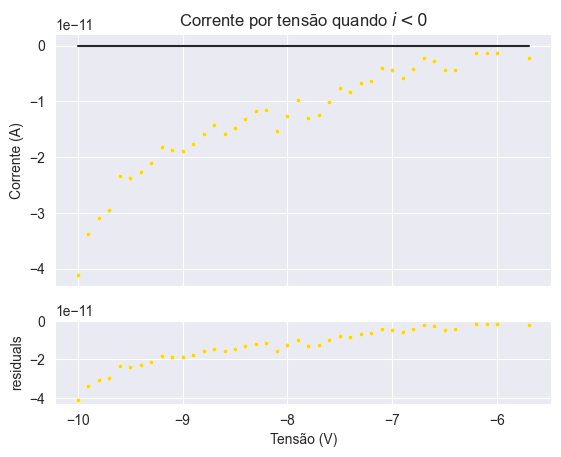

In [127]:
ep.residual_plot(Amarelo[Amarelo['i']<0]['V'],
                Amarelo[Amarelo['i']<0]['i'],
                efunc,
                (fit2[0], np.exp(fit2[1])), 
                r'Corrente por tensão quando $i<0$',
                points_color='gold',
                x_title='Tensão (V)',
                y_title='Corrente (A)')

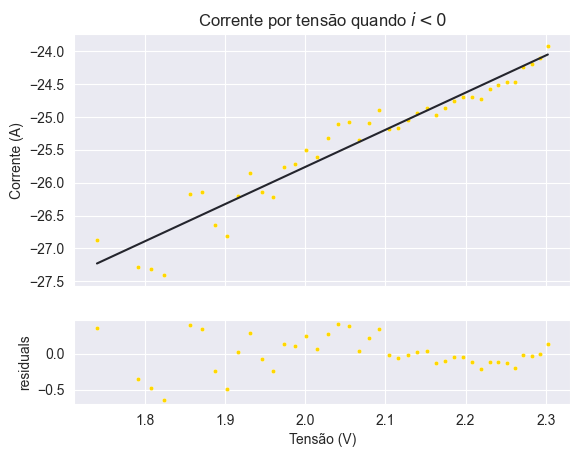

In [119]:
ep.residual_plot(np.log(abs(Amarelo[Amarelo['i']<0]['V'])),
                np.log(abs(Amarelo[Amarelo['i']<0]['i'])),
                logfunc,
                fit2, 
                r'Corrente por tensão quando $i<0$',
                points_color='gold',
                x_title='Tensão (V)',
                y_title='Corrente (A)')

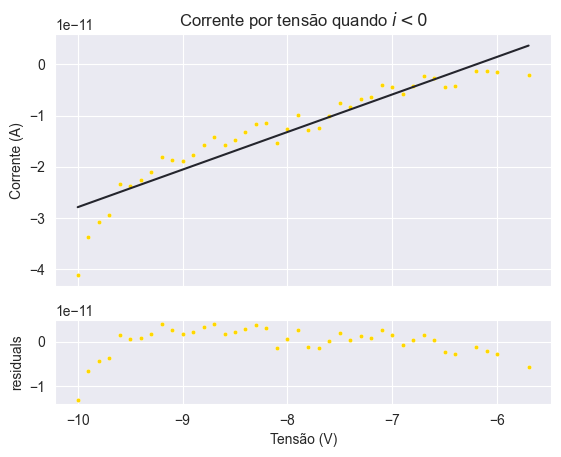

In [114]:
ep.residual_plot(Amarelo[Amarelo['i']<0]['V'],
                  Amarelo[Amarelo['i']<0]['i'],
                lfunc,
                fit1, 
                r'Corrente por tensão quando $i<0$',
                points_color='gold',
                x_title='Tensão (V)',
                y_title='Corrente (A)')

## Gráficos

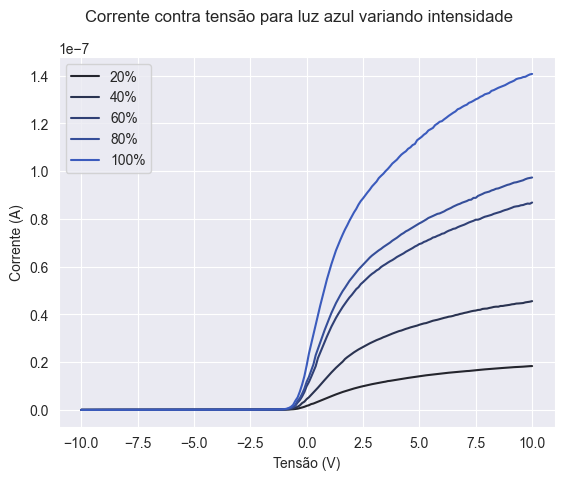

In [111]:
sns.set_palette(sns.dark_palette( 'royalblue'))
sns.lineplot(x=A20['V'], y=A20['i'],label = '20%')
sns.lineplot(x=A40['V'], y=A40['i'], label = '40%' )
sns.lineplot(x=A60['V'], y=A60['i'], label = '60%')
sns.lineplot(x=A80['V'], y=A80['i'], label = '80%')
sns.lineplot(x=A100['V'], y=A100['i'], label = '100%')

plt.legend()

plt.xlabel("Tensão (V)")
plt.ylabel('Corrente (A)')

plt.suptitle('Corrente contra tensão para luz azul variando intensidade')


plt.savefig('plots/azul_intensidade.png')
plt.show()



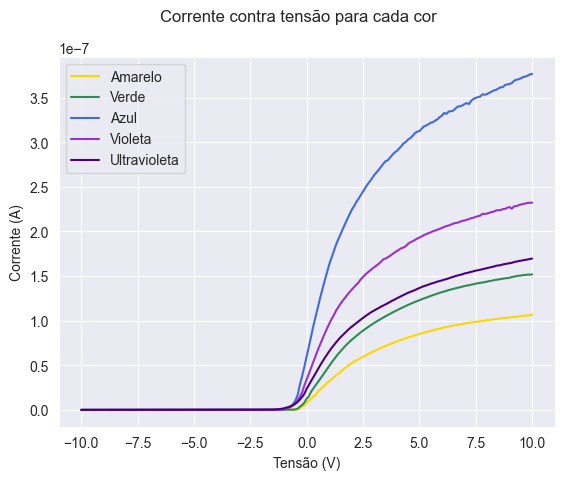

In [112]:
sns.lineplot(x=Amarelo['V'], y=Amarelo['i'],label = 'Amarelo', c='gold')
sns.lineplot(x=Verde['V'], y=Verde['i'], label = 'Verde', c='seagreen')
sns.lineplot(x=Azul['V'], y=Azul['i'], label = 'Azul', c='royalblue')
sns.lineplot(x=Violeta['V'], y=Violeta['i'], label = 'Violeta', c='darkorchid')
sns.lineplot(x=Ultra['V'], y=Ultra['i'], label = 'Ultravioleta', c='indigo')

plt.legend()

plt.xlabel("Tensão (V)")
plt.ylabel('Corrente (A)')

plt.suptitle('Corrente contra tensão para cada cor')


plt.savefig('plots/cores.png')
plt.show()

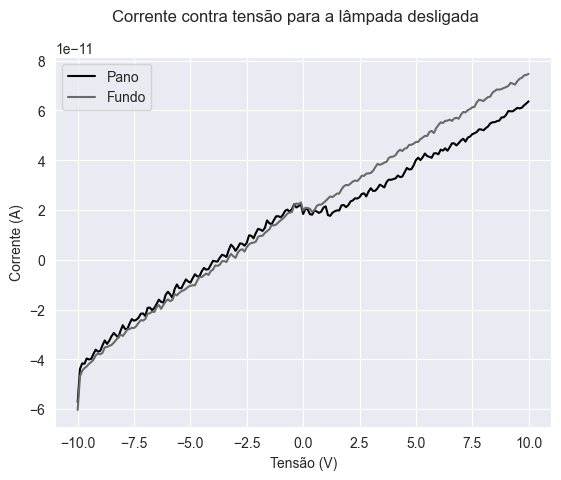

In [113]:
sns.lineplot(x=Preto['V'], y=Preto['i'], label = 'Pano', c ='black')
sns.lineplot(x=Fundo['V'], y=Fundo['i'], label = 'Fundo', c = 'dimgray')

plt.legend()

plt.xlabel("Tensão (V)")
plt.ylabel('Corrente (A)')

plt.suptitle('Corrente contra tensão para a lâmpada desligada')


plt.savefig('plots/fundo.png')


plt.show()